In [1]:
import time
from datetime import datetime
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from conv_sparse_model import ConvSparseLayer
from small_data_classifier import SmallDataClassifier
from train_conv3d_sparse_model import load_balls_data
from train_conv3d_sparse_model import plot_original_vs_recon
from train_conv3d_sparse_model import plot_filters
from train_conv3d_sparse_model import plot_video

from BamcPreprocessor import BamcPreprocessor
from video_loader import MinMaxScaler
from video_loader import VideoGrayScaler
from video_loader import VideoLoader
from video_loader import VideoClipLoader

from load_data import load_bamc_data

from IPython.display import HTML

In [2]:
batch_size = 62
video_path = "/shared_data/bamc_data"

width = 350
height = 200

transforms = torchvision.transforms.Compose([VideoGrayScaler(),
                                             MinMaxScaler(0, 255),
                                             BamcPreprocessor(),
                                             torchvision.transforms.Resize(size=(height, width))
                                            ])
dataset = VideoLoader(video_path, transform=transforms, num_frames=60)

targets = dataset.get_labels()

train_idx, test_idx = train_test_split(np.arange(len(targets)), test_size=0.2, shuffle=True, stratify=targets)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           # shuffle=True,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                # shuffle=True,
                                                sampler=test_sampler)

In [59]:
example_data = next(iter(test_loader))

torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])
torch.Size([1, 60, 1080, 1920])


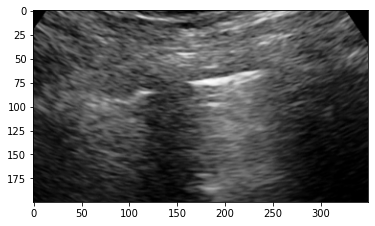

In [74]:
plt.imshow(example_data[1][0, 0, 10, :, :], cmap=cm.Greys_r)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    batch_size = 1
else:
    batch_size = 4*3
    # batch_size = 3

# train_loader = load_balls_data(batch_size)
train_loader, test_loader = load_bamc_data(batch_size)

example_data = next(iter(train_loader))

sparse_layer = ConvSparseLayer(in_channels=1,
                               out_channels=24,
                               kernel_size=(4, 16, 16),
                               stride=2,
                               padding=0,
                               convo_dim=3,
                               rectifier=True,
                               shrink=0.05,
                               lam=0.05,
                               max_activation_iter=300,
                               activation_lr=1e-2)
model = sparse_layer
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
model.to(device)

learning_rate = 3e-4
optimizer = torch.optim.Adam(sparse_layer.parameters(),
                                    lr=learning_rate)
#optimizer = torch.optim.SGD(sparse_layer.parameters(),
#                            momentum=0.9,
#                            lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-14, max_lr=1e-5,step_size_up=20,mode="triangular2")

criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Load models if we'd like to
checkpoint = torch.load("saved_models/sparse_conv3d_model-best.pt")
model.module.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Put everything on the target device
model.to(device)

In [ ]:
example_data[1].shape

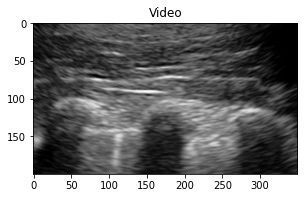

In [77]:
ani = plot_video(example_data[1][2])
HTML(ani.to_html5_video())

In [ ]:
loss_log = []
best_so_far = float('inf')

for epoch in tqdm(range(300)):
    epoch_loss = 0
    epoch_start = time.perf_counter()
    # for local_batch in train_loader:
    for labels, local_batch in train_loader:
        local_batch = local_batch.to(device)
        
        # pred, activations = model(local_batch)
        activations = model(local_batch)
        loss = sparse_layer.loss(local_batch, activations)
        # loss += criterion(pred, torch_labels)
        # print('epoch={}, loss={:.2f}'.format(epoch, loss))
        epoch_loss += loss.item() * local_batch.size(0)
        # print('l:', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sparse_layer.normalize_weights()
    
    epoch_end = time.perf_counter()    
    epoch_loss /= len(train_loader.sampler)
    
    if epoch_loss < best_so_far:
        print("found better model")
        # Save model parameters
        torch.save({
            'model_state_dict': model.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, datetime.now().strftime("saved_models/sparse_conv3d_model-best.pt"))
        best_so_far = epoch_loss
        
    loss_log.append(epoch_loss)
    print('epoch={}, epoch_loss={:.2f}, time={:.2f}'.format(epoch, epoch_loss, epoch_end - epoch_start))
    # scheduler.step(epoch_loss)
    # scheduler.step()

In [ ]:
plt.plot(loss_log)

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
# Save model parameters
torch.save({
    'model_state_dict': model.module.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, datetime.now().strftime("saved_models/sparse_conv3d_model-%Y%m%d-%H%M%S.pt"))

In [ ]:
ani = plot_video(example_data[1][2])
HTML(ani.to_html5_video())

In [ ]:
idx=1
activations = sparse_layer(example_data[1][idx:idx+1].to(device))
reconstructions = sparse_layer.reconstructions(
    activations).cpu().detach().numpy()

ani = plot_video(reconstructions.squeeze(0))
# ani = plot_original_vs_recon(example_data[1][idx:idx+1], reconstructions, idx=0)
HTML(ani.to_html5_video())

In [ ]:
ani = plot_filters(sparse_layer.filters.cpu().detach())
HTML(ani.to_html5_video())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallDataClassifier(nn.Module):
    
    def __init__(self, sparse_layer):
        super().__init__()

        self.sparse_layer = sparse_layer
        
        self.pool = nn.MaxPool3d(2, 2)
        
        self.dropout3d = torch.nn.Dropout3d(p=0.1, inplace=False)
        self.dropout = torch.nn.Dropout(p=0.5, inplace=False)
        
        # First fully connected layer
        self.fc1 = nn.Linear(5462100, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    # x represents our data
    def forward(self, x):
        # Pass data through conv1
        activations = self.sparse_layer(x)
        
        # x = self.dropout3d(x)
        
        # Flatten x with start_dim=1
        x = torch.flatten(activations, 1)
        
        # print(x.shape)
        
        # Pass data through fc1
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x, activations

In [ ]:
# Build a frozen sparse layer then add a small data classifier on top
frozen_sparse = ConvSparseLayer(in_channels=1,
                                out_channels=25,
                                kernel_size=(20, 16, 16),
                                stride=(2, 4, 4),
                                padding=0,
                                convo_dim=3,
                                rectifier=True,
                                shrink=0.25,
                                lam=0.25,
                                max_activation_iter=200,
                                activation_lr=1e-2)
sparse_param = torch.load("saved_models/sparse_conv3d_model-best.pt")
frozen_sparse.load_state_dict(sparse_param['model_state_dict'])
        
for param in frozen_sparse.parameters():
    param.requires_grad = False

predictive_model = torch.nn.DataParallel(SmallDataClassifier(frozen_sparse), device_ids=[0,1,2,3])
predictive_model.to(device)

learning_rate = 1e-2
prediction_optimizer = torch.optim.Adam(predictive_model.parameters(),
                                        lr=learning_rate)

criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
device = "cuda:0"
predictive_model.to(device)

idx=3
predictive_model(example_data[1][idx:idx+1].to(device))

In [ ]:
model.train()
for epoch in range(3):
    epoch_loss = 0
    # for local_batch in train_loader:
    t1 = time.perf_counter()
    for labels, local_batch in train_loader:
        local_batch = local_batch.to(device)
        
        torch_labels = torch.zeros(len(labels))
        torch_labels[[i for i in range(len(labels)) if labels[i] == 'PTX_No_Sliding']] = 1
        torch_labels = torch_labels.unsqueeze(1).to(device)
        
        pred, activations = predictive_model(local_batch)
        
        loss = criterion(pred, torch_labels)
        # loss += frozen_sparse.loss(local_batch, activations)
        epoch_loss += loss.item() * local_batch.size(0)
        
        prediction_optimizer.zero_grad()
        loss.backward()
        prediction_optimizer.step()
        
    t2 = time.perf_counter()
    print('epoch={}, time={:.2f}, loss={:.2f}'.format(epoch, t2-t1, loss))

In [ ]:
model.eval()
with torch.no_grad():
    epoch_loss = 0
    
    y_h = None
    y = None
    
    error = None
    
    t1 = time.perf_counter()
    # for local_batch in train_loader:
    for labels, local_batch in test_loader:
        local_batch = local_batch.to(device)

        torch_labels = torch.zeros(len(labels))
        torch_labels[[i for i in range(len(labels)) if labels[i] == 'PTX_No_Sliding']] = 1
        torch_labels = torch_labels.unsqueeze(1).to(device)

        
        pred, _ = predictive_model(local_batch)
        
        loss = criterion(pred, torch_labels)
        epoch_loss += loss.item() * local_batch.size(0)

        if error is None:
            error = torch.abs(torch_labels - torch.nn.Sigmoid()(pred).round()).flatten()
            y_h = torch.nn.Sigmoid()(pred).round().flatten()
            y = torch_labels.flatten()
        else:
            error = torch.cat((error, torch.abs(torch_labels - torch.nn.Sigmoid()(pred).round()).flatten()))
            y_h = torch.cat((y_h, torch.nn.Sigmoid()(pred).round().flatten()))
            y = torch.cat((y, torch_labels.flatten()))
            
    t2 = time.perf_counter()
    
    print('loss={:.2f}, time={:.2f}'.format(loss, t2-t1))
        
    print("Overall error={:.2f}".format(error.mean()))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y.cpu(), y_h.cpu())

cm_display = ConfusionMatrixDisplay(cm).plot()